In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
!pip install opencv-python-headless
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
base_path = '/kaggle/input/voronoi-artificial-grains-gen/GRAIN DATA SET/'
ag_path = os.path.join(base_path, 'AG')
ag_mask_path = os.path.join(base_path, 'AGMask')
rg_path = os.path.join(base_path, 'RG')
rg_mask_path = os.path.join(base_path, 'RGMask')
print(f"AG files: {len(os.listdir(ag_path))}")
print(f"AGMask files: {len(os.listdir(ag_mask_path))}")
print(f"RG files: {len(os.listdir(rg_path))}")
print(f"RGMask files: {len(os.listdir(rg_mask_path))}")

Using device: cuda
AG files: 800
AGMask files: 800
RG files: 480
RGMask files: 480


In [2]:
## Dataset
class GrainDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        mask = Image.open(self.mask_paths[idx]).convert('L')
        image = np.array(image, dtype=np.float32) / 255.0
        mask = np.array(mask, dtype=np.float32) / 255.0
        mask = np.where(mask > 0.5, 1.0, 0.0)
        image = torch.from_numpy(image).unsqueeze(0)
        mask = torch.from_numpy(mask).unsqueeze(0)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

# ViT requires square input divisible by patch size (16)
transform = transforms.Compose([transforms.Resize((320, 320))])  # 320 = 16 * 20
ag_images = sorted([os.path.join(ag_path, f) for f in os.listdir(ag_path)])
ag_masks = sorted([os.path.join(ag_mask_path, f) for f in os.listdir(ag_mask_path)])
rg_images = sorted([os.path.join(rg_path, f) for f in os.listdir(rg_path)])
rg_masks = sorted([os.path.join(rg_mask_path, f) for f in os.listdir(rg_mask_path)])
ag_train_img, ag_test_img, ag_train_mask, ag_test_mask = train_test_split(ag_images, ag_masks, test_size=0.2, random_state=42)
rg_train_img, rg_test_img, rg_train_mask, rg_test_mask = train_test_split(rg_images, rg_masks, test_size=0.2, random_state=42)
train_images = rg_train_img[:len(rg_train_img)//2] + ag_train_img[:len(ag_train_img)//2]
train_masks = rg_train_mask[:len(rg_train_mask)//2] + ag_train_mask[:len(ag_train_mask)//2]
test_images = rg_test_img + ag_test_img
test_masks = rg_test_mask + ag_test_mask
train_dataset = GrainDataset(train_images, train_masks, transform=transform)
test_dataset = GrainDataset(test_images, test_masks, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [9]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=320, patch_size=16, in_channels=1, embed_dim=256):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.zeros(1, self.n_patches, embed_dim))

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        x = x + self.pos_embed
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=256, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)
        return x

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim=256, num_heads=8, mlp_dim=512):
        super(TransformerEncoderLayer, self).__init__()
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(0.1)
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=320, patch_size=16, in_channels=1, embed_dim=256, num_heads=8, num_layers=6, mlp_dim=512):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.encoder = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, mlp_dim) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embed_dim, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        for layer in self.encoder:
            x = layer(x)
        x = self.norm(x)
        x = x[:, 1:]
        B = x.shape[0]
        x = x.transpose(1, 2).view(B, 256, 20, 20)
        x = self.decoder(x)
        return x

vit_model = VisionTransformer().to(device)

In [10]:
# define loss and optimizer
criterion_vit = nn.BCEWithLogitsLoss()
optimizer_vit = optim.Adam(vit_model.parameters(), lr=0.001)

In [11]:
## Train
# ViT Training
for epoch in range(25):
    vit_model.train()
    running_loss = 0.0
    for i, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device)
        logits = vit_model(images)
        loss = criterion_vit(logits, masks)
        optimizer_vit.zero_grad()
        loss.backward()
        optimizer_vit.step()
        running_loss += loss.item()
    print(f"ViT Epoch [{epoch+1}/25], Average Loss: {running_loss/len(train_loader):.4f}")
torch.save(vit_model.state_dict(), 'vit_grain_segmentation.pth')

ViT Epoch [1/25], Average Loss: 0.4450
ViT Epoch [2/25], Average Loss: 0.4125
ViT Epoch [3/25], Average Loss: 0.3842
ViT Epoch [4/25], Average Loss: 0.3547
ViT Epoch [5/25], Average Loss: 0.3446
ViT Epoch [6/25], Average Loss: 0.3412
ViT Epoch [7/25], Average Loss: 0.3264
ViT Epoch [8/25], Average Loss: 0.3119
ViT Epoch [9/25], Average Loss: 0.3083
ViT Epoch [10/25], Average Loss: 0.3014
ViT Epoch [11/25], Average Loss: 0.2935
ViT Epoch [12/25], Average Loss: 0.2877
ViT Epoch [13/25], Average Loss: 0.2821
ViT Epoch [14/25], Average Loss: 0.2765
ViT Epoch [15/25], Average Loss: 0.2714
ViT Epoch [16/25], Average Loss: 0.2667
ViT Epoch [17/25], Average Loss: 0.2625
ViT Epoch [18/25], Average Loss: 0.2594
ViT Epoch [19/25], Average Loss: 0.2568
ViT Epoch [20/25], Average Loss: 0.2547
ViT Epoch [21/25], Average Loss: 0.2513
ViT Epoch [22/25], Average Loss: 0.2494
ViT Epoch [23/25], Average Loss: 0.2461
ViT Epoch [24/25], Average Loss: 0.2437
ViT Epoch [25/25], Average Loss: 0.2413



ViT Evaluation Results:
Average Test Loss: 0.2515
Average Dice Score: 0.9351
Average Predicted Grain Size: 118.99 pixels
Average True Grain Size: 67.76 pixels
Average Grain Size Difference: 51.23 pixels


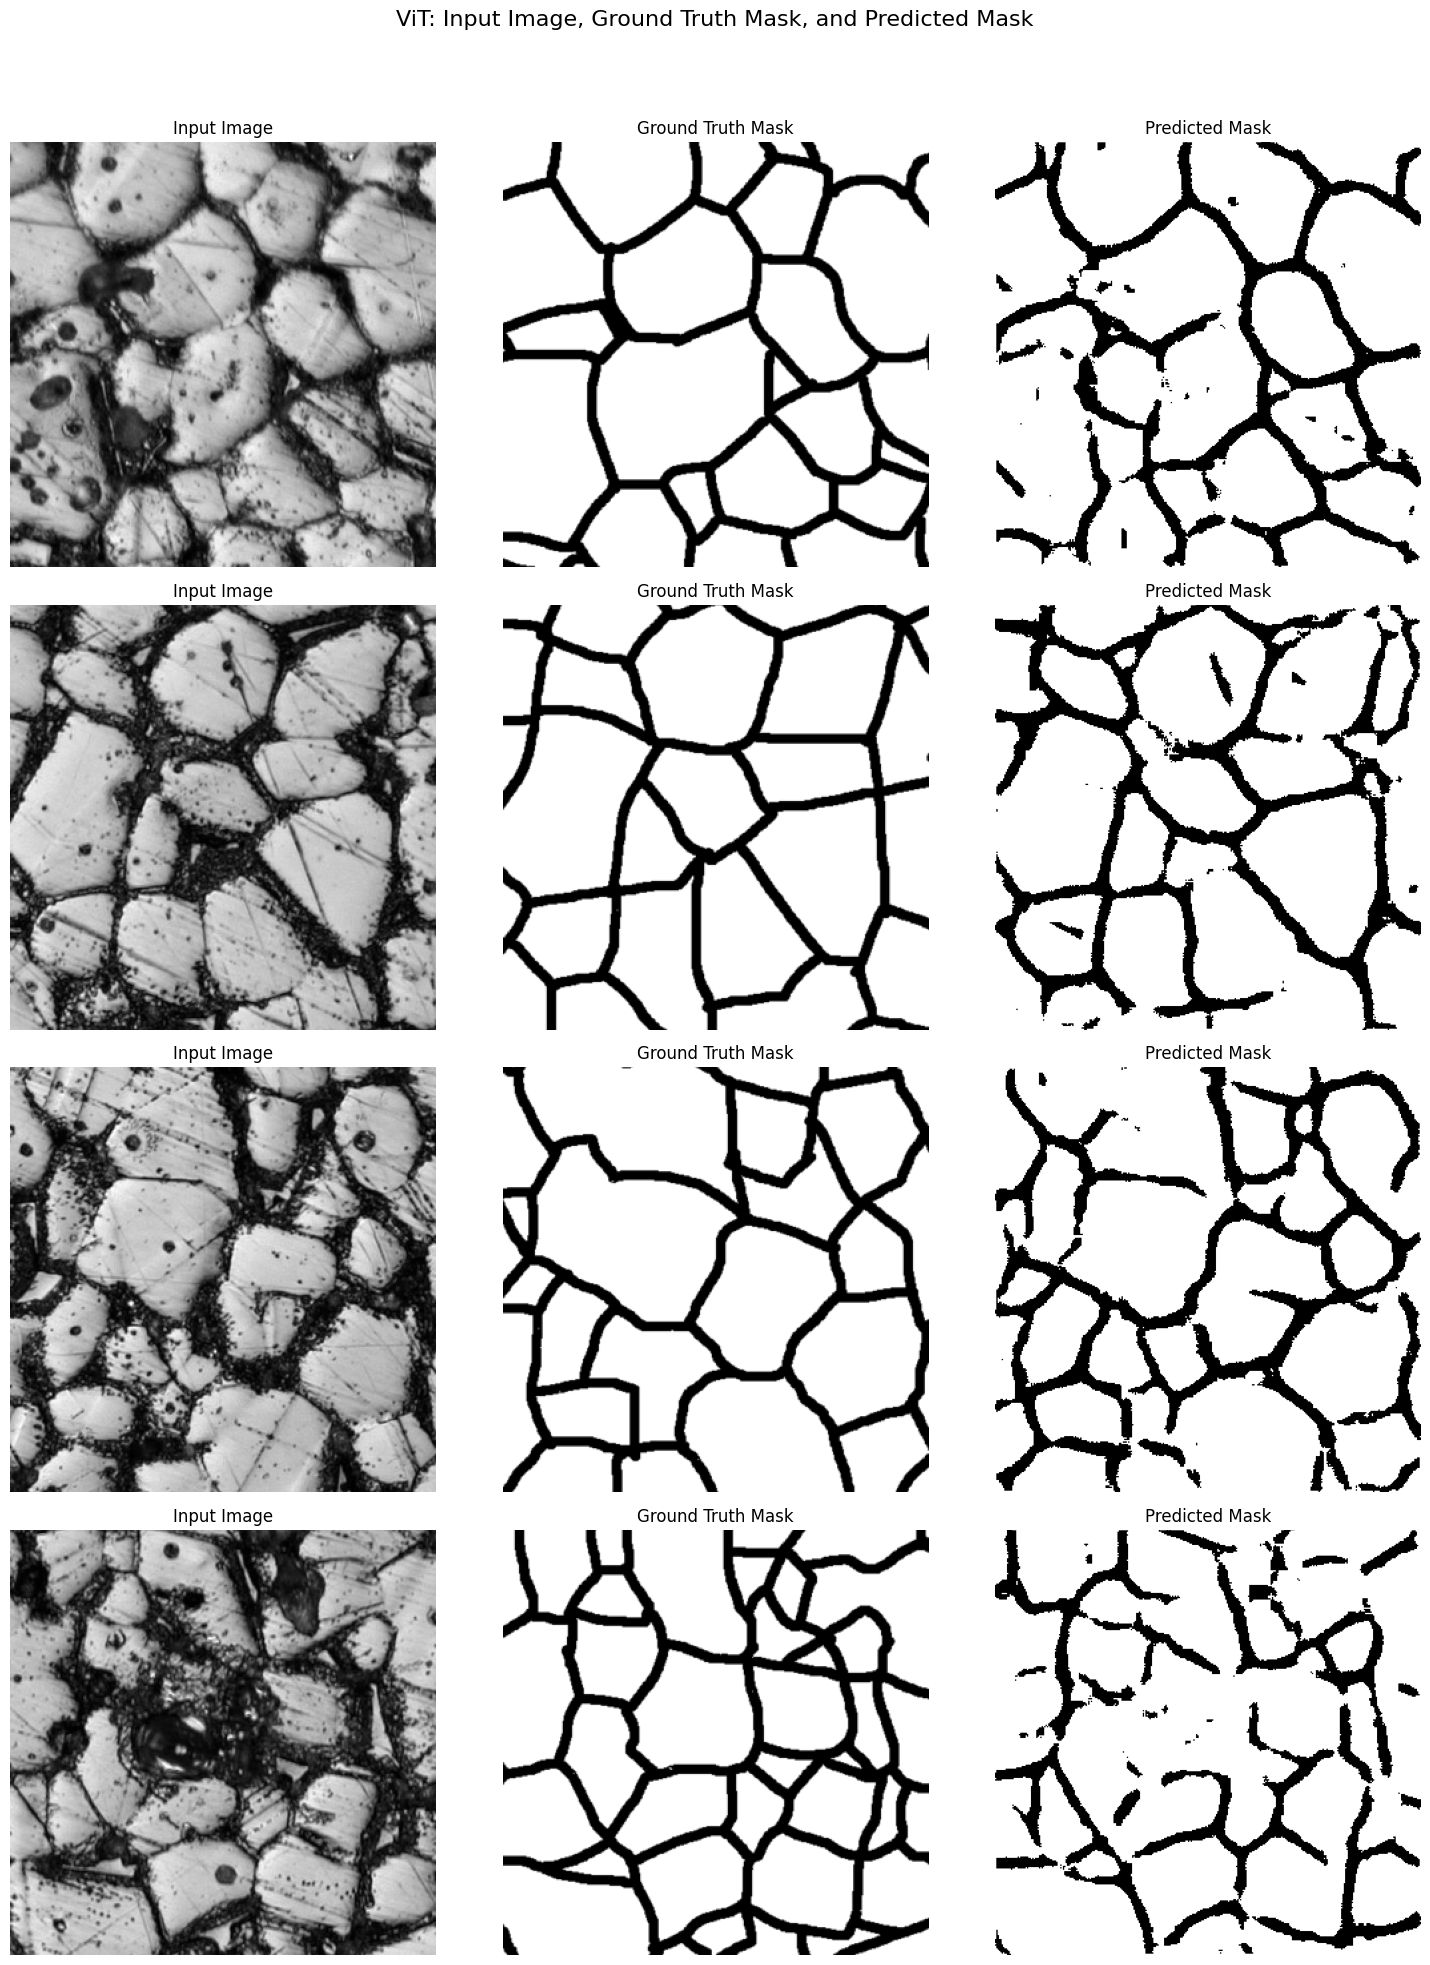

In [16]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

# Assuming vit_model, test_loader, criterion_vit, and device are already defined from your code

# Step 1: Define Evaluation Metrics (Reusing Existing Functions)
def dice_score(pred, target, smooth=1e-5):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def line_intercept_grain_size(mask, pixel_size=1.0):
    mask = (mask > 0.5).astype(np.uint8) * 255
    height, width = mask.shape
    line = mask[height // 2, :]
    edges = cv2.Canny(line.reshape(1, -1), 100, 200)
    num_intercepts = np.sum(edges > 0) // 2
    grain_size = (width * pixel_size) / num_intercepts if num_intercepts > 0 else width * pixel_size
    return grain_size

# Step 2: Evaluate ViT Model
vit_model.eval()
dice_scores_vit = []
grain_sizes_pred_vit = []
grain_sizes_true_vit = []
vit_test_loss = 0.0
all_images = []
all_true_masks = []
all_pred_masks = []

with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(test_loader):
        images, masks = images.to(device), masks.to(device)
        logits = vit_model(images)
        
        # Compute loss
        loss = criterion_vit(logits, masks)
        vit_test_loss += loss.item()
        
        # Compute Dice score
        dice = dice_score(logits, masks)
        dice_scores_vit.append(dice.item())
        
        # Convert to numpy for grain size and visualization
        pred_probs = torch.sigmoid(logits).cpu().numpy()
        pred_masks = (pred_probs > 0.5).astype(np.float32)
        true_masks = masks.cpu().numpy()
        images_np = images.cpu().numpy()
        
        # Store for visualization (first batch only, for simplicity)
        if batch_idx == 0:
            all_images.extend(images_np)
            all_true_masks.extend(true_masks)
            all_pred_masks.extend(pred_masks)
        
        # Compute grain sizes
        for i in range(pred_masks.shape[0]):
            pred_mask = pred_masks[i, 0]
            true_mask = true_masks[i, 0]
            pred_size = line_intercept_grain_size(pred_mask)
            true_size = line_intercept_grain_size(true_mask)
            grain_sizes_pred_vit.append(pred_size)
            grain_sizes_true_vit.append(true_size)

# Calculate average metrics
avg_dice_vit = np.mean(dice_scores_vit)
avg_grain_size_pred_vit = np.mean(grain_sizes_pred_vit)
avg_grain_size_true_vit = np.mean(grain_sizes_true_vit)
avg_test_loss_vit = vit_test_loss / len(test_loader)

# Print evaluation results
print("\nViT Evaluation Results:")
print(f"Average Test Loss: {avg_test_loss_vit:.4f}")
print(f"Average Dice Score: {avg_dice_vit:.4f}")
print(f"Average Predicted Grain Size: {avg_grain_size_pred_vit:.2f} pixels")
print(f"Average True Grain Size: {avg_grain_size_true_vit:.2f} pixels")
print(f"Average Grain Size Difference: {avg_grain_size_pred_vit - avg_grain_size_true_vit:.2f} pixels")

# Step 3: Visualization
num_samples = min(4, len(all_images))  # Visualize up to 4 samples from the first batch
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
fig.suptitle("ViT: Input Image, Ground Truth Mask, and Predicted Mask", fontsize=16)

for i in range(num_samples):
    # Input Image
    axes[i, 0].imshow(all_images[i][0], cmap='gray')
    axes[i, 0].set_title("Input Image")
    axes[i, 0].axis('off')
    
    # Ground Truth Mask
    axes[i, 1].imshow(all_true_masks[i][0], cmap='gray')
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis('off')
    
    # Predicted Mask
    axes[i, 2].imshow(all_pred_masks[i][0], cmap='gray')
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

